 # Pine cone and document comparison engine
 Experiments with [Self Querying Retriever](https://python.langchain.com/v0.2/docs/how_to/self_query/)  
 [Notebook Ref.](https://github.com/EdIzaguirre/FilmSearchOpen/blob/main/rag_self_query.ipynb)
 

## Used Case
Given an input query about different files, the queries shall be mapped according to the files. 
The queries can have multiple file names in it. An example could be - Who's the author of both Abc.pdf and Cef.pdf. Typical RAG can only extract similarity searches, but we need to filter metadata, that too in a dynamic way. 
There are several methods considered to get this work done. 
1. **Self-Query**  
   Creates filter and maps with the vector database.  
   Limitations:
   Does not work properly in this scenario.
   Further research is needed for this.

2. **Multi-query Retrieval**  
    The Multi-Query Retriever Approach enhances result consistency by retrieving multiple sets of documents based on varied interpretations of the original query, which is particularly advantageous when dealing with vague or imprecisely formulated queries.

   Limitations:
    Can only extract information from one document.

3. **Custom Agents**  
    Custom Agents and tools could be made to

   1. Retrieve the file names and form a sub-query with each of the file names
   2. Asks the retriever questions mapping the file name as metadata filter
   3. Will be autonomous and capable of chaining self-thoughts    

   This is supposed to be the best approach, but would need significant amout of time to develop custom agents and tools.

Let's look and the custom agent flow that can be created for the solution  
<br>
    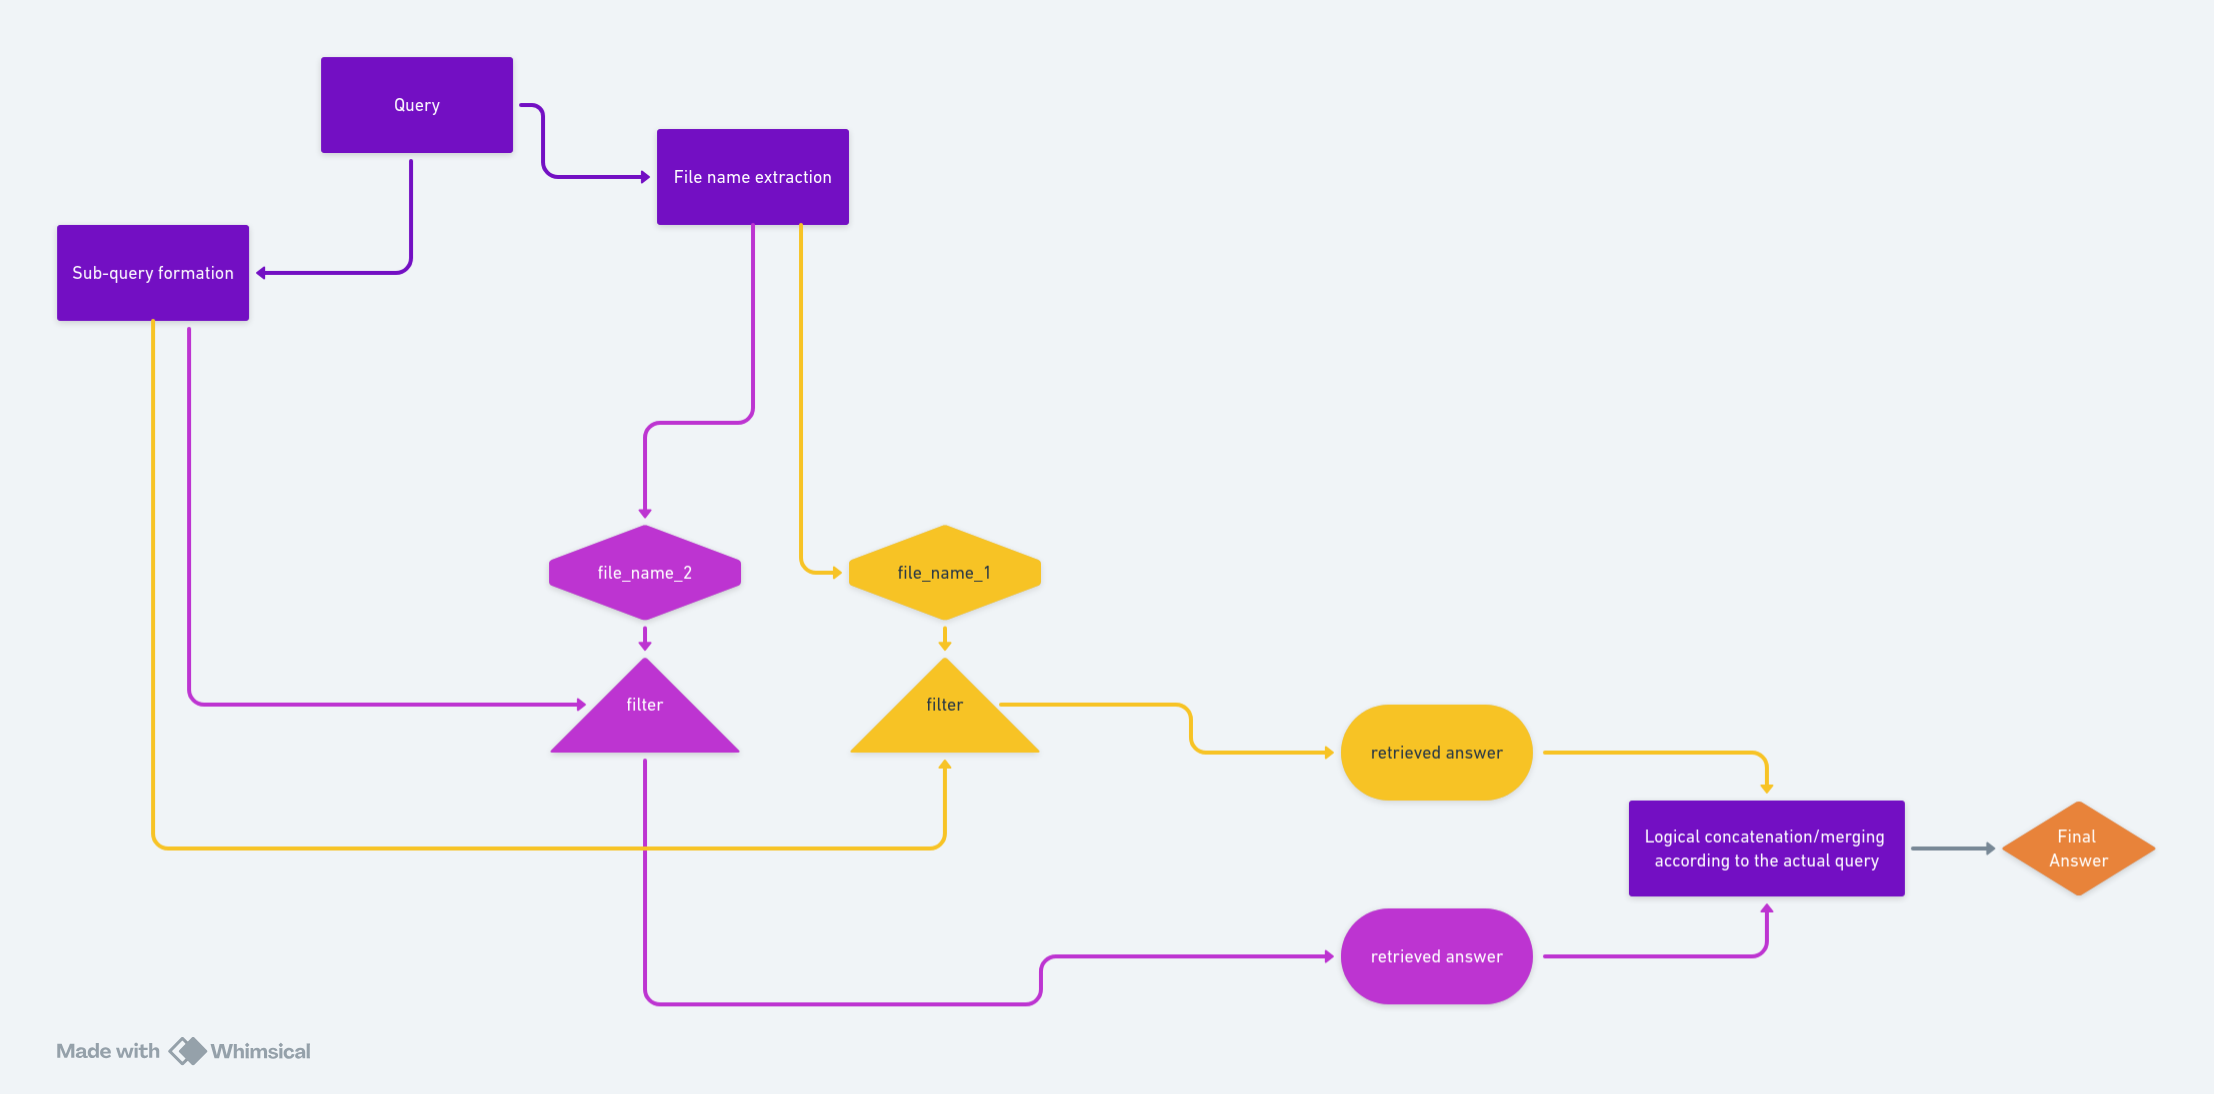


In [1]:
import os
os.chdir("..")
from dotenv import load_dotenv

from src.file_readers import ReadFiles
from src.entity.artifact_entity import FileHandlerArtifact
artifact = FileHandlerArtifact(
    file_storage_dir="artifacts/06_26_2024_12_48_34/file_storage/testmyne45"
)

from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000,
    chunk_overlap=200, 
    separators=["\n\n", "\n", " ", ""])


rd = ReadFiles(file_handler_artifact=artifact,
               text_splitter=splitter)

files = rd.read_all_files()

In [6]:
files["test1.txt"]["documents"]

[Document(page_content='LangChain is a powerful framework designed to assist in developing applications that leverage large language models (LLMs). Here are a few key points about LangChain:\n\n1. **Modular Components**:\n   - LangChain provides a set of modular components, such as document loaders, text splitters, LLM wrappers, and vector stores. These components can be easily combined to build custom language model applications.\n\n2. **Document Processing**:\n   - It offers utilities to process and manage documents of various formats (PDFs, Word documents, CSVs, etc.). These utilities help in loading, splitting, and indexing documents for efficient querying and retrieval.\n\n3. **Vector Stores**:\n   - LangChain integrates with multiple vector stores, enabling efficient storage and retrieval of embeddings. This is particularly useful for building applications that require semantic search or similarity matching.', metadata={'source': 'artifacts/06_26_2024_12_48_34/file_storage/testmy

In [4]:
for filename in files:
    print(filename)

test2.md
test1.txt
091923 DRAFT Budget_Northern Saints U9 Elite v3.xlsx
Contractor Guidelines_ort.txt


In [6]:
files["Contractor Guidelines_ort.txt"].keys()

dict_keys(['documents', 'file_type'])

In [7]:
for file_name in files:
    docs = files[file_name]["documents"]
    for doc in docs:
        doc.metadata["source"] = file_name
        doc.metadata["file_type"] = files[file_name]["file_type"]
        # print(doc.metadata)
    

In [19]:
from getpass import getpass
import os
# Pinecone

from pinecone import Pinecone, ServerlessSpec
from langchain.retrievers.self_query.pinecone import PineconeTranslator
from langchain_openai import (
    ChatOpenAI, 
    OpenAIEmbeddings
)
from langchain_pinecone import PineconeVectorStore
from langchain.indexes import SQLRecordManager, index
from dotenv import load_dotenv

load_dotenv()

# Create empty index
PINECONE_KEY, GROQ_KEY = os.getenv('PINECONE_API_KEY'), os.getenv("GROQ_API_LEY")

PINECONE_INDEX_NAME = "test-docs-1"
pc = Pinecone(api_key=PINECONE_KEY)

In [20]:


existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if PINECONE_INDEX_NAME not in existing_indexes:
    pc.create_index(
        name=PINECONE_INDEX_NAME,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(PINECONE_INDEX_NAME).status["ready"]:
        time.sleep(1)

pc_index = pc.Index(PINECONE_INDEX_NAME)
print(pc_index.describe_index_stats())

embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

vectorstore = PineconeVectorStore(
    pc_index, embeddings
)

# Create record manager
namespace = f"pinecone/{PINECONE_INDEX_NAME}"
record_manager = SQLRecordManager(
    namespace, db_url="sqlite:///record_manager_cache.sql"
)

record_manager.create_schema()


{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}


In [21]:

def upload_docs_to_pinecone(docs: list,
                           record_manager=None,
                           vectorstore=None):
    # Upload documents to pinecome
    index(docs, record_manager, vectorstore,
          cleanup="incremental", source_id_key="source")

In [22]:
for file_name in files:
    upload_docs_to_pinecone(docs=files[file_name]["documents"],
                           record_manager=record_manager,
                           vectorstore=vectorstore)
    
    

!pip install langchain-groq -q

In [23]:
from langchain_groq.chat_models import ChatGroq

llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768", groq_api_key=GROQ_KEY)

In [36]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    StructuredQueryOutputParser,
    get_query_constructor_prompt,
    AttributeInfo)

metadata_field_info = [
    AttributeInfo(
        name="source", description="The source of the file. Filename", type="string"),
    AttributeInfo(
        name="page", description="Page number of the document", type="int"),
    AttributeInfo(
        name="file_type", description="The type of the file. One of ['PDF', 'PPT', 'PPTX', 'DOCX', 'PNG', 'JPG', 'XLS', 'XLSX', 'CSV', 'MD', 'HTML', 'TXT'] ", type="string")
]

document_content_description = "Brief of the document contents, along with keywords"

retriever = SelfQueryRetriever.from_llm(
                            llm,
                            vectorstore,
                            document_content_description,
                            metadata_field_info,  
    structured_query_translator=PineconeTranslator(),
                            verbose=True)
                                
    


In [37]:
def chat_with_doc(query, filename):
    map_query_with_filename = f"{query} where filename={file_name}"
    return retriever.get_relevant_documents(map_query_with_filename)

In [33]:
file_name="Contractor Guidelines_ort.txt"
query = 'what is written in the file'

chat_with_doc(query, file_name)
    

[Document(page_content='CONTRACTOR’S RESPONSIBILITY FOR PROJECT SAFETY\nGuidance\nContract \n1. Contractor recognizes the importance of performing the Work in a safe and responsible manner so as to prevent damage, injury, or loss to individuals, the environment, and the Work, including materials and equipment incorporated into the Work or stored on-site or off-site. Contractor assumes responsibility for implementing and monitoring all Environment, Health & Safety (EHS) precautions and programs related to the performance of the Work.\n2. Contractor and Subcontractors shall comply with all legal and Owner-specific reporting', metadata={'file_type': 'TXT', 'source': 'Contractor Guidelines_ort.txt'}),
 Document(page_content='2. Contractor and Subcontractors shall comply with all legal and Owner-specific reporting\nrequirements relating to EHS set forth in the Contract Documents. Contractor will immediately report oral, and in writing within two (2) days, any EHS related injury, loss, damag

In [39]:
file_name="test2.md"
query = 'what is written in the file'

chat_with_doc(query, file_name)
    

[Document(page_content='Real-time Search Capabilities:\n\nThe framework supports real-time search capabilities, making it suitable for applications that require instant retrieval of information, such as chatbots and real-time analytics platforms.\n\nCommunity and Documentation:\n\nLlamaIndex has a supportive community and comprehensive documentation, providing developers with the resources they need to effectively use and extend the framework.\n\nOpen Source:\n\nLlamaIndex is an open-source project, encouraging collaboration and contributions from the developer community, which helps in continuously improving the framework.\n\nThese points illustrate how LlamaIndex can be a valuable tool for developers looking to build efficient, scalable, and customizable indexing and retrieval systems, especially when working with large language models.\n\nauthor - hrisikesh neogi.', metadata={'file_type': 'MD', 'source': 'test2.md'}),
 Document(page_content='LlamaIndex can handle various data format

In [18]:
# Let's compare with the actual document

In [44]:
!pip install langchainhub -q

## Defining tools to retrieve data from vector database

In [53]:
file_name="test2.md"
query = 'what is written in the file'
vectorstore.similarity_search_with_relevance_scores(query+file_name)

[(Document(page_content='Real-time Search Capabilities:\n\nThe framework supports real-time search capabilities, making it suitable for applications that require instant retrieval of information, such as chatbots and real-time analytics platforms.\n\nCommunity and Documentation:\n\nLlamaIndex has a supportive community and comprehensive documentation, providing developers with the resources they need to effectively use and extend the framework.\n\nOpen Source:\n\nLlamaIndex is an open-source project, encouraging collaboration and contributions from the developer community, which helps in continuously improving the framework.\n\nThese points illustrate how LlamaIndex can be a valuable tool for developers looking to build efficient, scalable, and customizable indexing and retrieval systems, especially when working with large language models.\n\nauthor - hrisikesh neogi.', metadata={'file_type': 'MD', 'source': 'test2.md'}),
  0.8530221284999999),
 (Document(page_content='LlamaIndex is a 

In [63]:
file_name="test2.md"
query = 'what is written in the file '


retriever = vectorstore.as_retriever(search_kwargs={#"k": 1, 
                                                    'filter': {'source':{'$eq': file_name}}
                                                   }
                                    )


retrieval_prompt = """
Based on the user's query, prepare a list of questions that 
"""

## Using Multiquery Retriever
The Multi-Query Retriever Approach in Retrieval-Augmented Generation (RAG) enhances result consistency by retrieving multiple sets of documents based on varied interpretations of the original query, which is particularly advantageous when dealing with vague or imprecisely formulated queries.  
[Follow the blog](https://readmedium.com/en/https:/medium.com/@kbdhunga/advanced-rag-multi-query-retriever-approach-ad8cd0ea0f5b)

In [100]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=model
)

# RAG prompt
template = """Answer the question based only on the following context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# RAG
model = ChatOpenAI()
chain = (
    RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    | prompt
    | model
    | StrOutputParser()
)




In [89]:
!pip install -qU lark

In [83]:
file_name="test2.md"
query = 'what is written in the file '
chain.invoke(query+ file_name)

'The file test2.md contains information about LlamaIndex, a versatile and efficient data indexing and retrieval framework designed to work seamlessly with large language models. Sources: test2.md'

In [102]:
def chat_with_doc(query, filename):
    map_query_with_filename = f"{query} filename={file_name}"
    return chain.invoke(map_query_with_filename)

In [104]:
file_name="test2.md and test1.txt"
query = "Who's the author of"

chat_with_doc(query, file_name)

'The author of the document with filename test2.md is Hrisikesh Neogi. The author of the document with filename test1.txt is not specified in the provided context.'

# Retrieval with sources chain

In [47]:

from langchain.chains import RetrievalQAWithSourcesChain

chain = RetrievalQAWithSourcesChain.from_chain_type(llm, 
                                                chain_type="stuff", 
                                                    retriever=retriever)



## Custom Agents and tools 
<br>

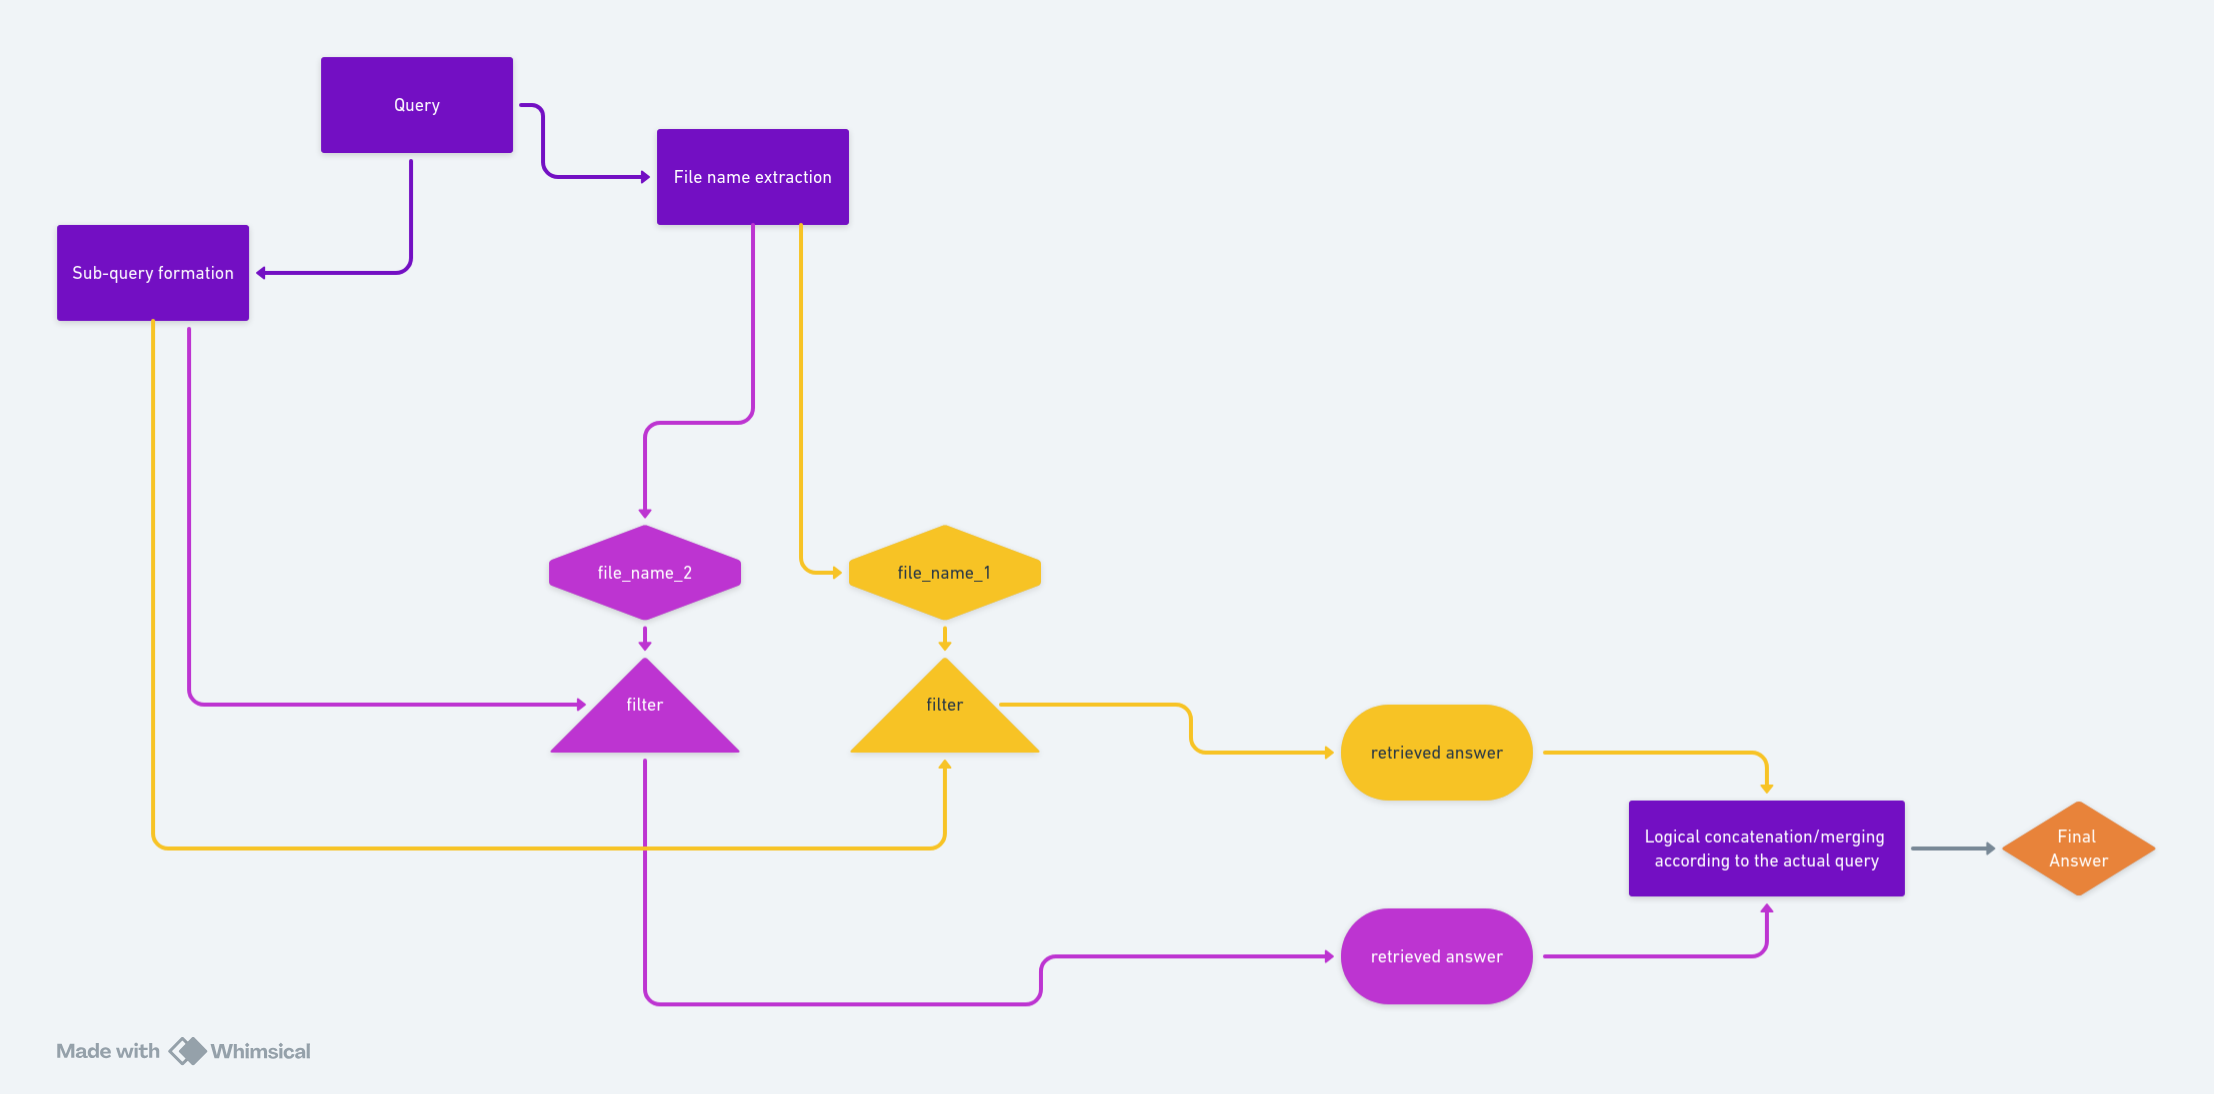

In [ ]:
# Import things that are needed generically
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

vector_search_prompt = """
"""


@tool
def vector_search(query:str, file_name:str ) -> str:
    pc_index.query()
    